Projeto da Disciplina SRI - Prof Flávio Codeço Coelho - Aluno: Gilberto Ramos - 30.11.2021
## Mapeamento de Similaridade Musical com dados do Spotify usando a biblioteca Gensim/Word2Vec e a modelagem de Distância de Cosseno.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm

# Fonte do Dataset Spotify

fonte do Dataset: Kaggle 
(https://www.kaggle.com/geomack/spotifyclassification) Este é um dataset de atributos de músicas da base do Spotify de 2019/2020, inclui atributos como:
acústica, dançabilidade, duração, energia, instrumentalidade, etc..
Usaremos esses recursos para gerar os embeddings de palavras para cada música e, em seguida, comparar as semelhanças entre as diferentes músicas. 


In [ ]:
from google.colab import files 
uploaded = files.upload()
df = pd.read_csv('data_spotify9.csv',sep=";")



Saving data_spotify9.csv to data_spotify9.csv


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_title        2004 non-null   object 
 1   artist            2004 non-null   object 
 2   acousticness      2004 non-null   float64
 3   danceability      2004 non-null   float64
 4   duration_ms       2004 non-null   int64  
 5   energy            2004 non-null   float64
 6   instrumentalness  2004 non-null   object 
 7   key               2004 non-null   int64  
 8   liveness          2004 non-null   float64
 9   loudness          2004 non-null   float64
 10  mode              2004 non-null   int64  
 11  speechiness       2004 non-null   float64
 12  tempo             2004 non-null   float64
 13  time_signature    2004 non-null   float64
 14  valence           2004 non-null   float64
 15  target            2004 non-null   int64  
dtypes: float64(9), int64(4), object(3)
memory 

In [ ]:
df.head(5)

,song_title,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
0,Slyd,!!!,0.0626,0.858,254920,0.717,0.243,0,0.2160,-8.734,1,0.0995,120.004,4.0,0.593,1
1,Bye Bye Bye,NSYNC,0.0198,0.571,199640,0.870,6.6e-06,8,0.0564,-3.877,0,0.0641,172.716,4.0,0.815,0
2,God Must Have Spent a Little More Time on You ...,NSYNC,0.4400,0.468,243493,0.535,0.0,10,0.1010,-8.264,1,0.0436,168.001,4.0,0.298,0
3,I Want You Back - Radio Edit,NSYNC,0.0743,0.754,199787,0.946,0.000391,8,0.4010,-2.149,0,0.0403,112.042,4.0,0.865,0
4,It's Gonna Be Me,NSYNC,0.0479,0.647,191280,0.870,0.0,0,0.0485,-4.702,0,0.0798,165.103,4.0,0.906,0


## **Compreendendo os atributos do Dataset:** 
>**Danceability**: descreve como uma faixa é adequada para dançar com base em uma combinação de elementos musicais, incluindo andamento, estabilidade do ritmo, intensidade da batida e regularidade geral.

>**Valence**: Descreve a positividade musical transmitida por uma faixa. Faixas com alta valência soam mais positivas (por exemplo, feliz, alegre, eufórico), enquanto faixas com baixa valência soam mais negativas (por exemplo, triste, deprimido, com raiva).

>**Energy**: representa uma medida perceptiva de intensidade e atividade. Normalmente, as faixas energéticas parecem rápidas, altas e barulhentas. Por exemplo, death metal tem alta energia, enquanto um prelúdio de Bach tem pontuação baixa na escala.

>**Tempo**: O tempo estimado geral de uma faixa em batidas por minuto (BPM). Na terminologia musical, o tempo é a velocidade ou ritmo de uma determinada peça e deriva diretamente da duração média do tempo.

>**Loudness**: O volume geral de uma faixa em decibéis (dB). Os valores de sonoridade são calculados em toda a trilha e são úteis para comparar a sonoridade relativa das trilhas.

>**Speechiness**: detecta a presença de palavras faladas em uma faixa. Quanto mais exclusivamente falada for a gravação (por exemplo, talk show, audiolivro, poesia), mais próximo de 1,0 será o valor do atributo.

>**Instrumentalness**: prevê se uma faixa não contém vocais. Os sons “Ooh” e “aah” são tratados como instrumentais neste contexto. Faixas de rap ou palavra falada são claramente “vocais”.

>**Liveness**: detecta a presença de um público na gravação. Valores de vivacidade mais altos representam um aumento na probabilidade de a trilha ter sido executada ao vivo.

>**Acousticness**: Uma medida de confiança de 0,0 a 1,0 de se a faixa é acústica.

>**Key**: a chave estimada da faixa(tonalidade/escala). Os inteiros mapeiam o pithbend usando a notação de classe de pitch padrão. Por exemplo. 0 = C, 1 = C♯ / D ♭, 2 = D e assim por diante.

>**Mode**: indica a modalidade/tonalidade (maior ou menor) de uma faixa, o tipo de escala da qual seu conteúdo melódico é derivado. Maior é representado por 1 e menor é 0.

>**Duration_ms**: a duração da trilha em milissegundos.

>**Signature**: uma fórmula de compasso estimada de uma faixa. A fórmula de compasso (medidor) é uma convenção de notação para especificar quantas batidas existem em cada compasso.

In [ ]:
duplicados = df[df.duplicated(keep='first')]
print(duplicados)

                         song_title         artist  ...  valence  target
159                            Myth    Beach House  ...    0.404       1
250                            Jack         Breach  ...    0.614       1
822                           River          Ibeyi  ...    0.111       1
921   Episode I - Duel of The Fates  John Williams  ...    0.217       1
1176                    Her Fantasy   Matthew Dear  ...    0.207       1

[5 rows x 16 columns]


In [ ]:
df.drop_duplicates(keep='first', inplace=True) 

In [ ]:
duplicados = df[df.duplicated(keep='first')]
print(duplicados)

Empty DataFrame
Columns: [song_title, artist, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence, target]
Index: []


In [ ]:
df.head(5)

,song_title,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
0,Slyd,!!!,0.0626,0.858,254920,0.717,0.243,0,0.2160,-8.734,1,0.0995,120.004,4.0,0.593,1
1,Bye Bye Bye,NSYNC,0.0198,0.571,199640,0.870,6.6e-06,8,0.0564,-3.877,0,0.0641,172.716,4.0,0.815,0
2,God Must Have Spent a Little More Time on You ...,NSYNC,0.4400,0.468,243493,0.535,0.0,10,0.1010,-8.264,1,0.0436,168.001,4.0,0.298,0
3,I Want You Back - Radio Edit,NSYNC,0.0743,0.754,199787,0.946,0.000391,8,0.4010,-2.149,0,0.0403,112.042,4.0,0.865,0
4,It's Gonna Be Me,NSYNC,0.0479,0.647,191280,0.870,0.0,0,0.0485,-4.702,0,0.0798,165.103,4.0,0.906,0


In [ ]:
df.isna().sum()

song_title          0
artist              0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
dtype: int64

In [ ]:
df.isnull().sum()

song_title          0
artist              0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
dtype: int64

In [ ]:
df.describe()

,acousticness,danceability,duration_ms,energy,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1999.000000,1999.000000,1.999000e+03,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,0.186497,0.618457,2.462214e+05,0.682768,5.347174,0.191052,-7.066971,0.612806,0.092745,121.666359,3.967984,0.497832,0.506753
std,0.258725,0.160679,8.217726e+04,0.209856,3.648128,0.155789,3.758154,0.487230,0.089742,26.692706,0.256985,0.247086,0.500079
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009550,0.514000,1.999730e+05,0.564000,2.000000,0.092200,-8.392500,0.000000,0.037500,100.241500,4.000000,0.296000,0.000000
50%,0.062800,0.631000,2.289330e+05,0.717000,6.000000,0.127000,-6.240000,1.000000,0.055000,121.797000,4.000000,0.493000,1.000000
75%,0.263000,0.737500,2.703800e+05,0.847000,9.000000,0.247000,-4.732500,1.000000,0.108000,137.746500,4.000000,0.692000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


# Pré-processamento dos dados

passo 1: efetuar uma EDA(análise exploratória de dados)

passo2: gerar embeddings de palavras usando a biblioteca gensim/word2vec. 

passo3: seleção de features para o modelo word2vec.
obs: Gensim-word2Vec requer um formato de lista de lista para treinamento onde cada documento está contido em uma lista e cada lista contém uma lista de tokens desse documento. 

Primeiramente, precisamos gerar um formato de lista de lista para treinar a incorporação de palavras do modelo. Cada música está contida em uma lista e cada lista contém uma lista de recursos/atributos dessa música. 
Para tanto, vamos seguir as seguintes etapas de pré-processamento de dados:

  >  Criar uma nova coluna para 'song_title' e 'artist', vou chamá-la de 'song_artist' (meu objetivo é mostrar a similaridade exibindo a música e o artista respectivo)

  >  Gerar um formato de lista de lista para cada tipo de música com os seguintes recursos: 

acústica(acousticness),dançabilidade(danceability),energia(energy),instrumentalidade(instrumentalness),vivacidade(liveness),loudness(volume),valence(valência)



1. Criei a nova coluna para as colunas song_title e artist -> 'song_artist'

In [ ]:
df['song_artist']= df['song_title']+ " " + df['artist']

2. Gerando um formato lista de lista para cada par 'song_title' 'artist' 

In [ ]:
# selecionar as features do dataset original p/ formar um novo dataframe 
df1 = df[['acousticness','danceability','energy','liveness','loudness','valence','song_artist']]

# Para cada linha, combinar todas as colunas em uma única coluna que vou chamar de 'bagOfWords'
df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1) 

# Alocá-la no nosso dataframe
df_bagOfWords = pd.DataFrame({'bagOfWords': df2}) 

# Criar no formato de lista de lista p/ um corpus customizado para modelagem do gensim.
lista_de_lista = [row.split(',') for row in df_bagOfWords['bagOfWords']]

# mostrando 2 linhas como exemplo de lista de lista do corpus customizado para modelagem do gensim.
lista_de_lista[:2] 

[['0.0626',
  '0.858',
  '0.7170000000000001',
  '0.21600000000000003',
  '-8.734',
  '0.593',
  'Slyd !!!'],
 ['0.0198',
  '0.5710000000000001',
  '0.87',
  '0.0564',
  '-3.877',
  '0.815',
  'Bye Bye Bye NSYNC']]

In [ ]:
df2.head(5)

0    0.0626,0.858,0.7170000000000001,0.216000000000...
1    0.0198,0.5710000000000001,0.87,0.0564,-3.877,0...
2    0.44,0.46799999999999997,0.535,0.1009999999999...
3    0.0743,0.754,0.946,0.401,-2.149,0.865,I Want Y...
4    0.0479,0.647,0.87,0.0485,-4.702,0.905999999999...
dtype: object

In [ ]:
df_bagOfWords.head()

,bagOfWords
0,"0.0626,0.858,0.7170000000000001,0.216000000000..."
1,"0.0198,0.5710000000000001,0.87,0.0564,-3.877,0..."
2,"0.44,0.46799999999999997,0.535,0.1009999999999..."
3,"0.0743,0.754,0.946,0.401,-2.149,0.865,I Want Y..."
4,"0.0479,0.647,0.87,0.0485,-4.702,0.905999999999..."


# Gensim-word2vec - Treinando o modelo 

Gensim é uma biblioteca python de código aberto para NLP e foi desenvolvida e mantida pelo pesquisador em NLP o tcheco Radim Rehurek e sua empresa RaRe Technologies(disponibilizada em https://radimrehurek.com/gensim/). A biblioteca Gensim nos permitirá desenvolver a incorporação de palavras(embedding) treinando nossos próprios modelos word2vec em um corpus customizado com algoritmos **CBOW** ou **skip-gram**.

>A principal diferença entre esses dois métodos é que o **CBOW** usa o contexto para prever uma palavra-alvo, enquanto o **skip-gram** usa uma palavra para prever um contexto-alvo. Geralmente, o método skip-gram pode ter um melhor desempenho em comparação com o método CBOW, pois pode capturar duas semânticas para uma única palavra. Por exemplo, ele terá duas representações vetoriais para a Apple, uma para a empresa e outra para a fruta.

In [ ]:
## Treino do modelo gensim word2vec com nosso próprio corpus personalizado
model = Word2Vec(lista_de_lista, min_count=1,size= 50,workers=3, window =5, sg = 1)

WARNING - 15:43:47: consider setting layer size to a multiple of 4 for greater performance
INFO - 15:43:47: collecting all words and their counts
INFO - 15:43:47: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:43:47: collected 5803 word types from a corpus of 13993 raw words and 1999 sentences
INFO - 15:43:47: Loading a fresh vocabulary
INFO - 15:43:47: effective_min_count=1 retains 5803 unique words (100% of original 5803, drops 0)
INFO - 15:43:47: effective_min_count=1 leaves 13993 word corpus (100% of original 13993, drops 0)
INFO - 15:43:47: deleting the raw counts dictionary of 5803 items
INFO - 15:43:47: sample=0.001 downsamples 0 most-common words
INFO - 15:43:47: downsampling leaves estimated 13993 word corpus (100.0% of prior 13993)
INFO - 15:43:48: estimated required memory for 5803 words and 50 dimensions: 5222700 bytes
INFO - 15:43:48: resetting layer weights
INFO - 15:43:49: training model with 3 workers on 5803 vocabulary and 50 features, usin

os hiperparâmetros deste modelo.
1. **size**: o número de dimensões dos embeddings-> o default é 100.
2. **window:** A distância máxima entre uma palavra-alvo e palavras ao redor da palavra-alvo-> A janela default é 5.
3. **min_count**: A contagem mínima de palavras a considerar ao treinar o modelo; palavras com ocorrência menor que 
essa contagem serão ignoradas-> O default para min_count é 5.
4. **workers**: O número de partições durante o treinamento-> o default é 3.
5. **sg**: O algoritmo de treinamento, CBOW (0) ou skip gram (1)-> O algoritmo de treinamento default é CBOW.

In [ ]:
## já podemos obter o word embedding diretamente do modelo treinado
## faremos isso usando como exemplo nossa combinação 'song_title'+'artist' com 
## song_title= 'Fuego' e 'artist = Alok'
## lembrar que nosso model se baseia na nova coluna 'song_artist'
model['Fuego Alok']

array([-0.00618517, -0.00915499,  0.00866003,  0.00665282, -0.0094017 ,
        0.00566219, -0.00437352,  0.0036672 , -0.00368397, -0.00607169,
       -0.00554488, -0.00706304,  0.00869587, -0.002759  ,  0.00574434,
       -0.00176496, -0.00092428,  0.00702009, -0.00164404,  0.00498295,
        0.00972895, -0.00397716,  0.00882494, -0.00980405, -0.00914672,
        0.00348564,  0.00674329, -0.00561374, -0.00326992, -0.00771396,
       -0.00672895,  0.00229752,  0.00034439, -0.00889511, -0.00659049,
       -0.00965193,  0.00635954, -0.0100636 ,  0.00199448,  0.00000016,
       -0.00408871, -0.00644499,  0.01019812, -0.00406083,  0.00863187,
       -0.00207373, -0.00286206,  0.00483409, -0.00778391, -0.00477298],
      dtype=float32)

# Calcular Similaridades 

Agora podemos até usar Word2vec para calcular a similaridade entre duas músicas no vocabulário invocando o 
model.similarity () e passando as palavras relevantes. Por exemplo, model.similarity ('Fuego Alok', 'Red Nose Sage The Gemini')
Isso nos dará a semelhança euclidiana entre o 'Fuego Alok' e 'Red Nose Sage The Gemini'.


In [ ]:
model.similarity('Fuego Alok', 'Red Nose Sage The Gemini')

-0.078444816

In [ ]:
model.similarity('Fuego Alok', 'Complicated Avril Lavigne')

0.090280294

In [ ]:
model.similarity('Fuego Alok', 'Fantasy Mariah Carey')

0.029571705

Pelo exemplo acima, podemos dizer que 'Fuego' do artista 'Alok' é mais parecida com 'Red Nose Sage' do artista 'The Gemini' do que com a música 'Complicated' do 
artista 'Avril Lavigne'. 
Também podemos usar a função build in model.most_similar () para obter um conjunto das músicas mais semelhantes para 
uma determinado música.


In [ ]:
## mostrando as músicas mais similares a 'Fuego' do artista 'Alok' : usando distancia euclidiana (default) 
## através do método most_similar.
model.most_similar('Fuego Alok')[:5]

INFO - 15:45:12: precomputing L2-norms of word weight vectors


[('-6.792000000000001', 0.51689213514328),
 ('Evil Friends (feat. Danny Brown) - Jake One Remix Portugal. The Man',
  0.4632382094860077),
 ('0.0511', 0.4566364586353302),
 ('It #1 Ty Segall', 0.44781479239463806),
 ('-8.729', 0.43879687786102295)]

In [ ]:
## mostrando as músicas mais similares a 'Complicated' do artista 'Avril Lavigne': usando distancia euclidiana (default) 
## através do método most_similar.
model.most_similar('Complicated Avril Lavigne')[:5]

[('Play This (Also) J Rocc', 0.5031095743179321),
 ('Huarache Lights Hot Chip', 0.4968010485172272),
 ('0.262', 0.4883107542991638),
 ('0.284', 0.4577000141143799),
 ('-5.341', 0.44435369968414307)]

**A diferença entre distância euclidiana e similaridade de cosseno.**

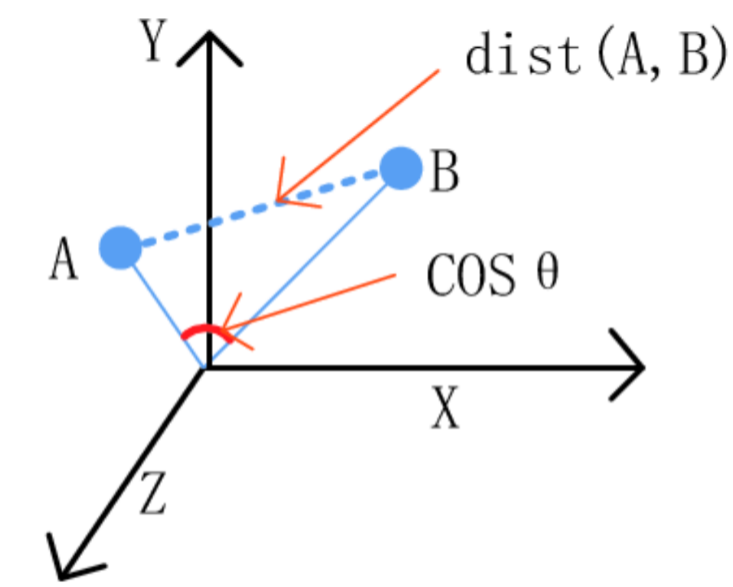

A distância euclidiana mede a distância entre dois pontos:

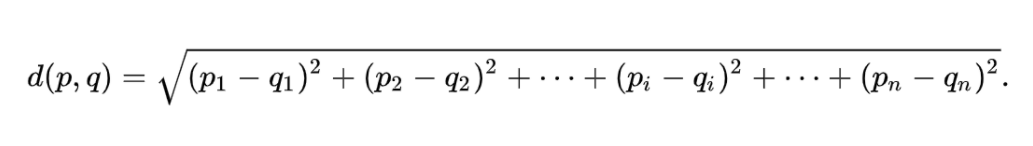

A similaridade de cosseno mede o ângulo entre os dois vetores:

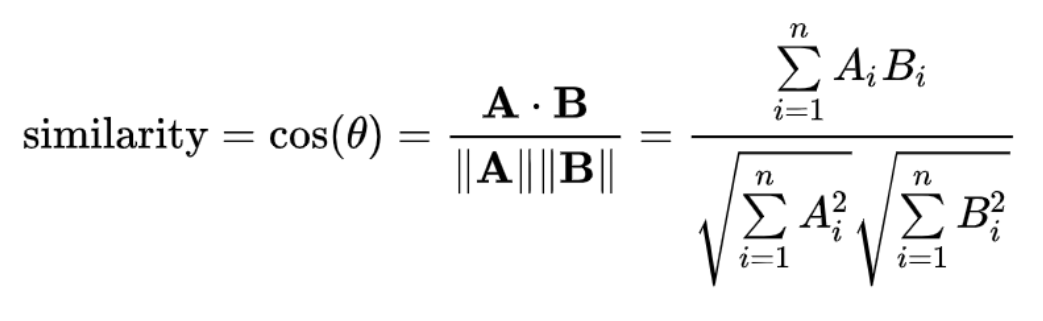

No entanto, a **similaridade por distância euclidiana** pode não funcionar bem para os vetores de palavras de alta dimensão. 
Isso ocorre porque a similaridade por distância euclidiana aumentará o número de dimensões, mesmo se a palavra incorporada(por embedding) 
tiver significados diferentes. Alternativamente, podemos usar a **similaridade de cosseno** para medir 
a similaridade entre dois vetores. Matematicamente, ele mede o cosseno do ângulo entre dois vetores projetados
em um espaço multidimensional. Portanto, a **similaridade do cosseno captura o ângulo dos vetores de palavras** 
e não a magnitude. Sob similaridade de cosseno, nenhuma similaridade é expressa com um ângulo de 90 graus(cos90°= 0), 
enquanto a similaridade total de 1 está em um ângulo de 0 graus. A função a seguir mostra como podemos gerar 
a música de maior semelhança com base na similaridade do cosseno.

In [ ]:
def distancia_cosseno (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

In [ ]:
song_artist = list(df.song_artist.unique()) ## only get the unique song_artist
## Show the most similar Childs Play Drake by cosine distance 
distancia_cosseno(model,'Fuego Alok',song_artist,5) 

[('Evil Friends (feat. Danny Brown) - Jake One Remix Portugal. The Man',
  0.46302328),
 ('It #1 Ty Segall', 0.44772598),
 ('Fools Rush In Teddy Wilson', 0.40884677),
 ('Issues Julia Michaels', 0.39734304),
 ("I'm A Martian Brian Pumper", 0.38792527)]

In [ ]:
song_artist = list(df.song_artist.unique()) ## only get the unique song_artist
## Show the most similar Childs Play Drake by cosine distance 
distancia_cosseno(model,'Complicated Avril Lavigne',song_artist,5) 

[('Play This (Also) J Rocc', 0.5031095),
 ('Huarache Lights Hot Chip', 0.49680105),
 ('Poison Martin Garrix', 0.409746),
 ('Brightside - Borgeous Remix Icona Pop', 0.39782217),
 ('Night And Day Hot Chip', 0.3961185)]

In [ ]:
song_artist = list(df.song_artist.unique()) ## only get the unique song_artist
## Show the most similar Childs Play Drake by cosine distance 
distancia_cosseno(model,'Lucky Britney Spears',song_artist,5) 

[('One Of Those Love Songs Xscape', 0.43129253),
 ('Caffeinated Consciousness TV On The Radio', 0.42579904),
 ('Despacito - Remix Luis Fonsi', 0.40307721),
 ('Swords M.I.A.', 0.3923923),
 ('Carl Sagan Night Moves', 0.38846627)]

# T-SNE Plot

É impraticável visualizar o embedding de palavras diretamente, pois geralmente tem mais de 3 dimensões. A modelagem t-SNE é uma ferramenta útil para visualizar dados de alta dimensão reduzindo o espaço dimensional enquanto mantém a distância relativa entre 
os pares de pontos. Pode-se dizer que t-SNE busca uma nova representação de dados onde as relações de vizinhança 
sejam preservadas. Usamos aqui o pacote TSNE da biblioteca scikit-learn. Para plotar o gráfico de embedding de palavras usamos T-SNE plot.

>O método de Stochastic Neighbor Embedding (t-SNE) com distribuição t é um método de redução de dimensionalidade, utilizado principalmente para visualização de dados em mapas 2D e 3D. Este método pode localizar conexões não lineares nos dados e, portanto, é muito popular.


In [ ]:
def ExibePalavrasProximas(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


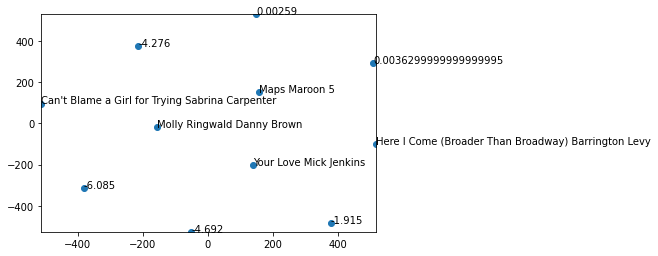

In [ ]:
ExibePalavrasProximas(model, 'Maps Maroon 5', 50)

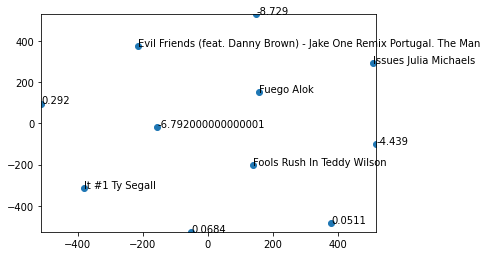

In [ ]:
ExibePalavrasProximas(model, 'Fuego Alok', 50)

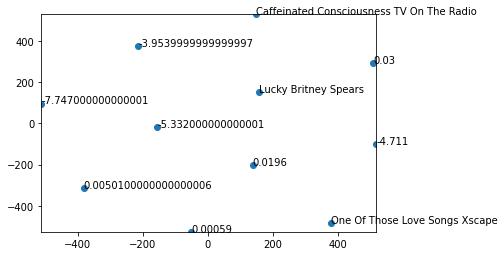

In [ ]:
ExibePalavrasProximas(model, 'Lucky Britney Spears', 50)